In [1]:
from datetime import datetime
import fur.path_assistant as path_assistant
from acnet_reader.fur_data_reader import save_acnet_data_for_fur
from config import get_from_config
shift = path_assistant.PathAssistant('shift_03_16_2020')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data
t1 = datetime(2020, 3, 16, 13, 46, 0)
t2 = datetime(2020, 3, 16, 14, 25, 0)

In [2]:
fluctuations_df = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)


In [3]:
fluctuations_df['real_datetime'].head()

0   2020-03-16 13:48:45
1   2020-03-16 13:49:08
2   2020-03-16 13:49:32
3   2020-03-16 13:49:56
4   2020-03-16 13:50:21
Name: real_datetime, dtype: datetime64[ns]

In [4]:
aux_df = shift.get_bpm_files_df()
aux1 = aux_df[aux_df['file_datetime']>t1]
bpm_df = aux1[aux1['file_datetime']<t2].reset_index(drop=True)
bpm_df.head()

,file_name,file_path,file_datetime
0,bunch_profile_03-16-2020_13_46_19_443909.csv,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-16 13:46:19.443909
1,bunch_profile_03-16-2020_13_48_59_864047.csv,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-16 13:48:59.864047
2,bunch_profile_03-16-2020_13_49_21_609623.csv,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-16 13:49:21.609623
3,bunch_profile_03-16-2020_13_49_51_068747.csv,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-16 13:49:51.068747
4,bunch_profile_03-16-2020_13_50_12_835559.csv,/mnt/c/Users/lobac_000/OneDrive - Fermi Nation...,2020-03-16 13:50:12.835559


In [5]:
wfs = [pd.read_csv(fp, index_col=0) for fp in bpm_df['file_path']]

<AxesSubplot:>

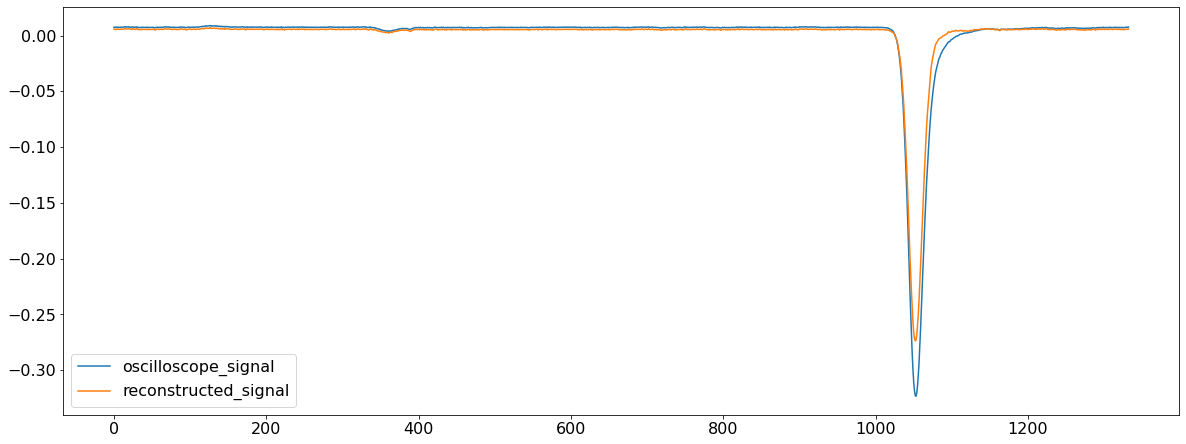

In [6]:
wfs[0].plot()

In [7]:
from physics_engine.bunch_length_estimators import \
    calc_fwhm, calc_rms, calc_phase_angle, calc_current,\
    calc_fur_length, calc_mad_length, calc_ramsg_currentg

In [8]:
np.unique([len(wf.index) for wf in wfs])

array([1333])

In [9]:
cur_calib = get_from_config("IWCMI_to_WCM_ABSOLUTE")

(20.0, 35.0)

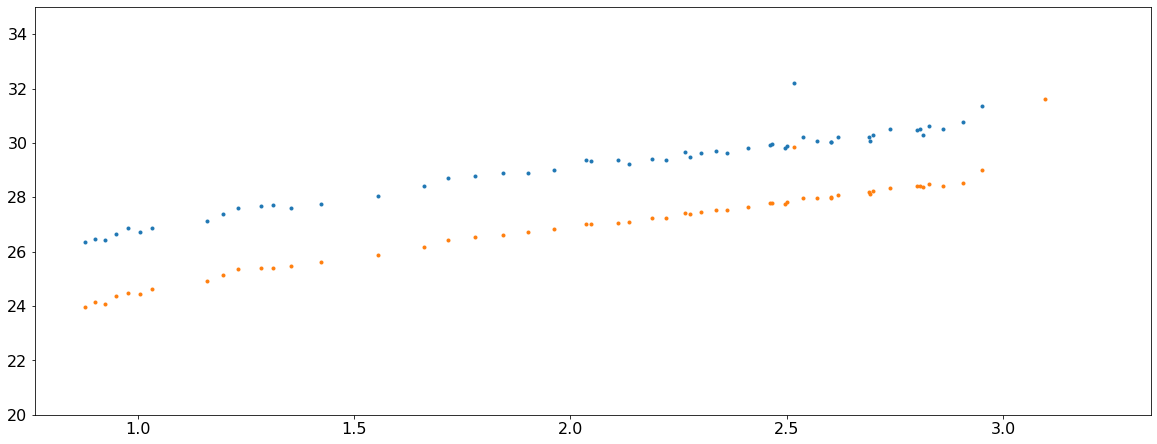

In [10]:
mbl = 10
rms_window = 2.5
dt = 0.1
n = 1333
time_arr = dt*np.arange(n)

res = []
for wf in wfs:
    reconstructed_signal = wf['reconstructed_signal'].values
    i_min = np.argmin(reconstructed_signal)
    t_min = time_arr[i_min]
    fwhm = calc_fwhm(reconstructed_signal, time_arr,
                                 t_min-mbl, t_min+mbl)
    rms_left_lim = t_min-rms_window*fwhm/30
    rms_right_lim = t_min+rms_window*fwhm/30
    rms = calc_rms(reconstructed_signal, time_arr,
                   rms_left_lim,
                   rms_right_lim)
    current = calc_current(reconstructed_signal, time_arr,
                           rms_left_lim,
                           rms_right_lim)
    fur = calc_fur_length(reconstructed_signal, time_arr,
                          rms_left_lim,
                          rms_right_lim)
    res.append({"current": -cur_calib*current, "rms": rms, "fur": fur})
    
res_df = pd.DataFrame(res)

fig, ax = plt.subplots()
ax.plot(res_df['current'], res_df['rms'], '.')
ax.plot(res_df['current'], res_df['fur'], '.')
ax.set_ylim(20,35)

(20.0, 40.0)

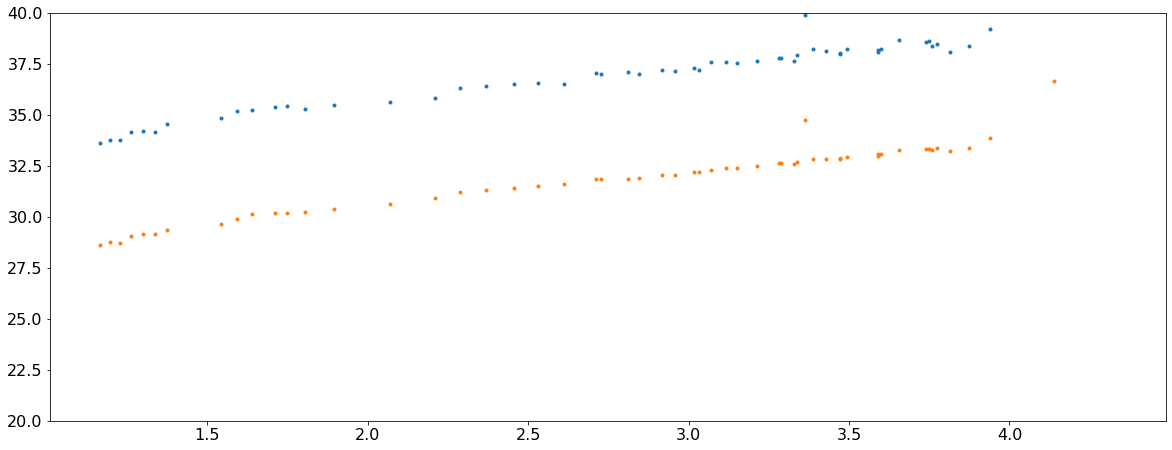

In [11]:
mbl = 10
rms_window = 2.5
dt = 0.1
n = 1333
time_arr = dt*np.arange(n)

res = []
for wf in wfs:
    reconstructed_signal = wf['oscilloscope_signal'].values
    i_min = np.argmin(reconstructed_signal)
    t_min = time_arr[i_min]
    fwhm = calc_fwhm(reconstructed_signal, time_arr,
                                 t_min-mbl, t_min+mbl)
    rms_left_lim = t_min-rms_window*fwhm/30
    rms_right_lim = t_min+rms_window*fwhm/30
    rms = calc_rms(reconstructed_signal, time_arr,
                   rms_left_lim,
                   rms_right_lim)
    current = calc_current(reconstructed_signal, time_arr,
                           rms_left_lim,
                           rms_right_lim)
    fur = calc_fur_length(reconstructed_signal, time_arr,
                          rms_left_lim,
                          rms_right_lim)
    res.append({"current": -cur_calib*current, "rms": rms, "fur": fur})
    
res_df = pd.DataFrame(res)

fig, ax = plt.subplots()
ax.plot(res_df['current'], res_df['rms'], '.')
ax.plot(res_df['current'], res_df['fur'], '.')
ax.set_ylim(20,40)

In [82]:
from server_modules.tcp_communication_with_scope import ConnectionToScope
from server_modules.initializations_for_gui import \
     init_bpm_signal_transfer_line
from physics_engine.bunch_profile_monitor import BunchProfileMonitor
from physics_engine.cable_amplifier_transfer_coefs import Amplifier, Cable, \
     SignalTransferLine, HeliaxCableHalfInch
from server_modules.initializations_for_gui import init_signal_transfer_line
iota_freq_MHz = 7.5
dt = 0.1

use_test_data = True
conn = ConnectionToScope(133.3,
                         dt, use_test_data)
bpm = BunchProfileMonitor(connection_to_scope=None, dt=dt)
bpm.v_arr = np.zeros(n)
bpm.perform_fft()
signal_transfer_line = init_signal_transfer_line(bpm.fourier_frequencies)

Text(0, 0.5, 'abs(transmission coef)')

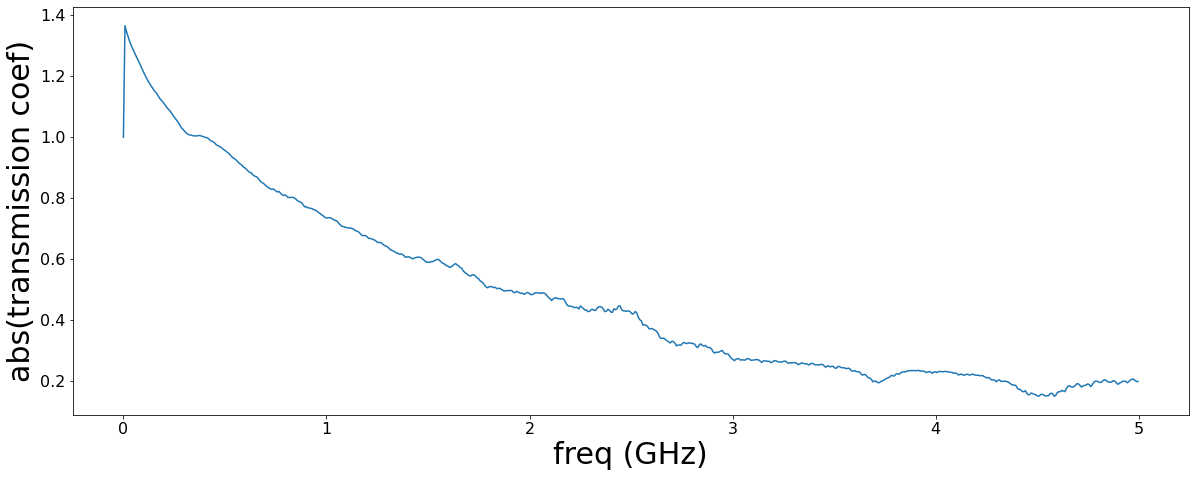

In [83]:
fig, ax = plt.subplots()
ax.plot(signal_transfer_line.freqs
        , signal_transfer_line.TransmissionCoefAbs)
ax.set_xlabel("freq (GHz)")
ax.set_ylabel("abs(transmission coef)")

In [128]:
wf = wfs[0]
v_arr = wf['oscilloscope_signal'].values
time_arr = dt*np.arange(n)
noise_rms = np.std(v_arr[(time_arr>40)&(time_arr<100)])
noise_rms

0.0002152695478454607

In [132]:
freq_cutoff = 2.5
bpm.transmission_coefs = \
        np.where(bpm.fourier_frequencies < freq_cutoff,
                 signal_transfer_line.transmission_coefs, 1)

wf = wfs[0]
res = []
for _ in range(1000):
    bpm.v_arr = wf['oscilloscope_signal'].values + np.random.normal(0, noise_rms, size=n)
    bpm.perform_fft()
    bpm.perform_signal_reconstruction()
    reconstructed_signal = bpm.reconstructed_signal
    original_signal = bpm.v_arr
    i_min = np.argmin(reconstructed_signal)
    t_min = time_arr[i_min]
    fwhm = calc_fwhm(reconstructed_signal, time_arr,
                                 t_min-mbl, t_min+mbl)
    rms_left_lim = t_min-rms_window*fwhm/30
    rms_right_lim = t_min+rms_window*fwhm/30
    rms = calc_rms(reconstructed_signal, time_arr,
                   rms_left_lim,
                   rms_right_lim)
    current = calc_current(reconstructed_signal, time_arr,
                           rms_left_lim,
                           rms_right_lim)
    fur = calc_fur_length(reconstructed_signal, time_arr,
                          rms_left_lim,
                          rms_right_lim)
    res.append({"current": -cur_calib*current, "rms": rms, "fur": fur})
res_df = pd.DataFrame(res)
# fig, ax = plt.subplots()
# ax.plot(bpm.time_arr, original_signal)
# ax.plot(bpm.time_arr, reconstructed_signal)
res_df['rms'].std()/res_df['rms'].mean()

0.0018447694226312737

In [134]:
from fur.path_assistant import get_plot_style_sheet
import matplotlib as mpl
mpl.use("pgf")
plt.style.use(get_plot_style_sheet("prab"))
plt.rc('pgf', preamble=r'\usepackage{amsmath}\usepackage{unicode-math}\usepackage{amsthm}\setmainfont{Times}\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}\let\mathbb\relax\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}'
       r'\usepackage{siunitx}')

(27.0, 33.0)

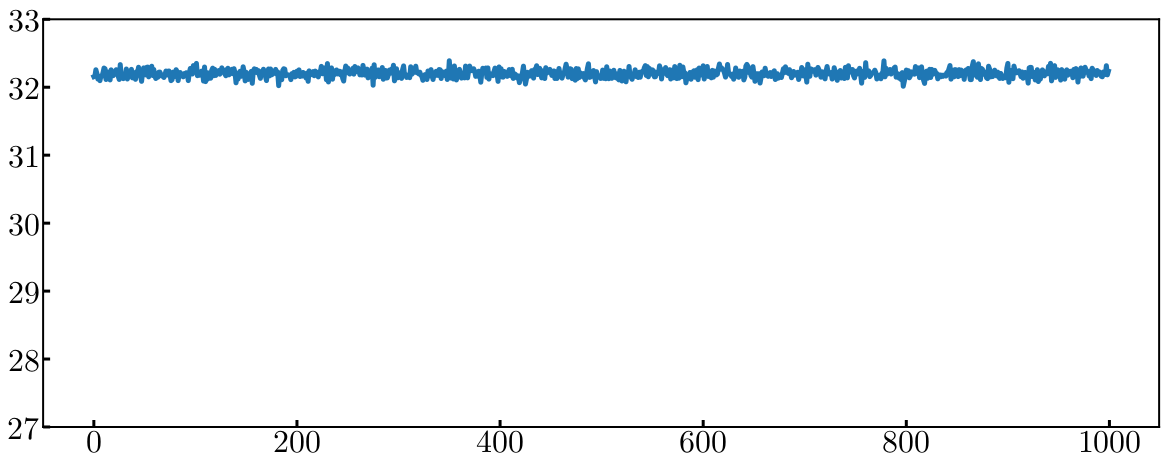

In [143]:
fig, ax = plt.subplots()
ax.plot(res_df['rms'], '-', linewidth=5)
ax.set_ylim(27,33)

In [89]:
res_df['rms']


0       39.895341
1       38.476956
2       38.690233
3       38.218341
4       38.218769
          ...    
6055    32.214551
6056    32.214551
6057    32.214551
6058    32.214551
6059    32.214551
Name: rms, Length: 6060, dtype: float64